# Take a single image

In [1]:
import numpy as np

import synpivimage as spi 
spi.__version__

'1.0.0'

## Configure laser, camera and particles

For the three main components of a PIV image classes exist. They are thought of the configuration of a synthetic PIV image

In [2]:
from synpivimage import take_image, Camera, Laser, Particles

In [3]:
cam = Camera(
    nx=16,
    ny=16,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=50,
    dark_noise=10,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=2
)

laser = Laser(
    width=0.25,
    shape_factor=2
)

The **particles** require the locations (or a single location only) and the size (arbitrary unit). Below, a single particle and randomly distributed ones are instantiated:

In [4]:
one_paricle = Particles(
    x=8,
    y=8,
    z=0,
    size=2
)


# note, that we purposely create particles outside the FOV and zplane. We'll see why later...
n = 40
many_paricles = Particles(
    x=np.random.uniform(-5, cam.nx-1, n),
    y=np.random.uniform(-10, cam.ny-1, n),
    z=np.random.uniform(-3*laser.width / 2, 3*laser.width/2, n),
    size=np.ones(n)*2
)

## Take the image

Just call `take_image` and pass the camera, laser and particle objects, Also define the particle count of an image particle located at z=0.

We receive the image and a particle object. Note, that the particle object has a `flag` property. We will use it later.

In [5]:
imgOne, partOne = take_image(laser, cam, one_paricle, particle_peak_count=1000)

(<Axes: >, <Axes: >)

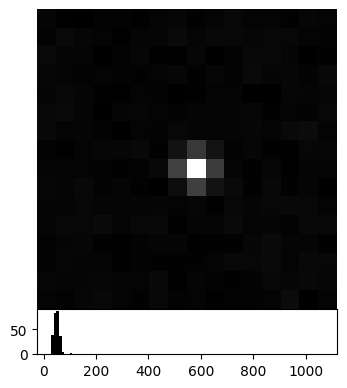

In [6]:
imgOne.plot()

**Print particle info**: The short information will tell us how many of the particles were illuminated. For the single particle, as expected, it got illuminated:

In [7]:
partOne.info()

=== Particle Information === 
 > Number of simulated particles: 1
 > Number of active (illuminated and in FOV) particles: 1
 > Number of particles outside of FOV: 0
 > Out of plane particles: 0


However, of the many particles, we expect some to be out of FOV or the laser:

In [8]:
imgMany, partMany = take_image(laser, cam, many_paricles, particle_peak_count=1000)

In [9]:
partMany.info()

=== Particle Information === 
 > Number of simulated particles: 40
 > Number of active (illuminated and in FOV) particles: 10
 > Number of particles outside of FOV: 26
 > Out of plane particles: 4


Let's mark the particles that are active in green, the other in red, those that are weakly illuminated are marked black:

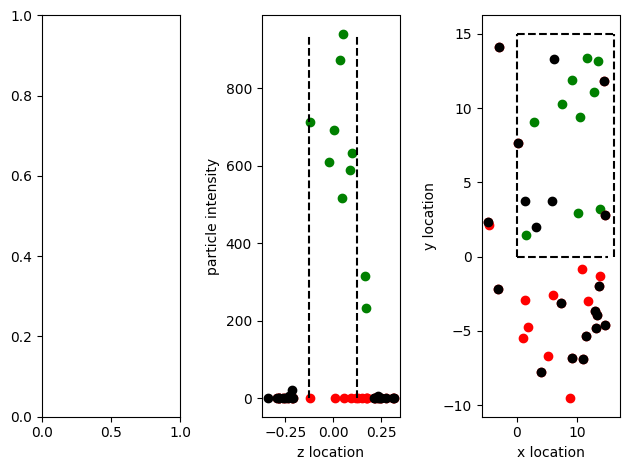

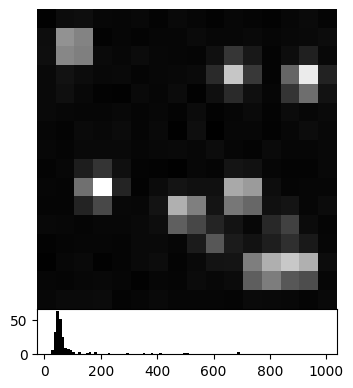

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, tight_layout=True)
imgMany.plot()

axs[1].scatter(partMany.z[partMany.active], partMany.max_image_photons[partMany.active], color='g')
axs[1].scatter(partMany.z[partMany.disabled], partMany.max_image_photons[partMany.disabled], color='r')
axs[1].scatter(partMany.z[partMany.out_of_plane], partMany.max_image_photons[partMany.out_of_plane], color='k')
axs[1].vlines(-laser.width/2, 0, partMany.max_image_photons.max(), color='k', linestyle='--')
axs[1].vlines(laser.width/2, 0, partMany.max_image_photons.max(), color='k', linestyle='--')
axs[1].set_xlabel('z location')
axs[1].set_ylabel('particle intensity')

axs[2].scatter(partMany.x[partMany.active], partMany.y[partMany.active], color='g')
axs[2].scatter(partMany.x[partMany.disabled], partMany.y[partMany.disabled], color='r')
axs[2].scatter(partMany.x[partMany.out_of_plane], partMany.y[partMany.out_of_plane], color='k')
axs[2].hlines(0, 0, cam.nx-1, color='k', linestyle='--')
axs[2].hlines(cam.ny-1, 0, cam.nx, color='k', linestyle='--')
axs[2].vlines(0, 0, cam.ny-1, color='k', linestyle='--')
axs[2].vlines(cam.nx, 0, cam.ny-1, color='k', linestyle='--')
axs[2].set_xlabel('x location')
axs[2].set_ylabel('y location')
plt.show()

**Compute particle numbers**

We might be interested in the particles in the laser sheet (source density number) and per pixel (ppp)

In [11]:
partMany.source_density_number

10

In [12]:
ppp = partMany.source_density_number/cam.size
ppp

0.0390625

## Save the data

We can save the data into an HDF5 file or as a TIF file. When writing to TIF, we can add metadata. Camera, laser and particles are expected parameters, but also additional kwargs can be passed, like "particle_peak_count":

### To image file

In [13]:
from synpivimage.io import Imwriter

In [14]:
with Imwriter(case_name='single_img', camera=cam, laser=laser, overwrite=True) as iw:
    iw.writeA(imgOne, partMany)

Preparing the folder
writing A image
Done
